# SHAP Explanations for DistilBERT

This notebook reuses the helper utilities in `src.analysis.shap_utils` to load text samples, compute SHAP values, and visualize the most influential tokens for the fine-tuned classifier.

In [1]:
from pathlib import Path
import sys

PROJECT_ROOT = Path.cwd()
if not (PROJECT_ROOT / "src").exists():
    PROJECT_ROOT = PROJECT_ROOT.parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))
PROJECT_ROOT

PosixPath('/home/erikhbj/Documents/tdt13/TDT13_AI_text_prediction')

In [2]:
import matplotlib.pyplot as plt
import shap

from src.analysis.shap_utils import (
    ShapConfig,
    aggregate_token_importance,
    build_text_classifier,
    compute_shap_values,
    load_test_texts,
    summarize_examples,
)


/home/erikhbj/Documents/tdt13/TDT13_AI_text_prediction/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
cfg = ShapConfig(
    checkpoint_path=Path("models/distilbert-debug"),
    num_samples=320,
    data_limit=50000,
    sample_seed=42,
    test_ratio=0.2,
)
cfg

ShapConfig(checkpoint_path=PosixPath('models/distilbert-debug'), num_samples=320, data_limit=50000, sample_seed=42, test_ratio=0.2, algorithm='partition', class_ratio=0.5)

In [4]:
texts, labels = load_test_texts(cfg, return_labels=True)
clf = build_text_classifier(cfg.checkpoint_path)
shap_values = compute_shap_values(clf, texts, algorithm=cfg.algorithm)
len(texts)


Device set to use cuda:0
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
PartitionExplainer explainer:  18%|█▊        | 58/320 [01:29<07:20,  1.68s/it]


KeyboardInterrupt: 

In [ ]:
shap_values

.values =
array([array([[-6.40316430e-04,  6.40316906e-04],
              [-6.40316430e-04,  6.40316906e-04],
              [-6.40316430e-04,  6.40316906e-04],
              [-6.40316430e-04,  6.40316906e-04],
              [-6.91414662e-03,  6.91414687e-03],
              [-6.91414662e-03,  6.91414687e-03],
              [-1.09326347e-02,  1.09326350e-02],
              [-1.09326347e-02,  1.09326350e-02],
              [-2.30172539e-03,  2.30172599e-03],
              [-2.30172539e-03,  2.30172599e-03],
              [-2.30172539e-03,  2.30172599e-03],
              [-2.30172539e-03,  2.30172599e-03],
              [-2.30172539e-03,  2.30172599e-03],
              [-4.23143200e-03,  4.23143222e-03],
              [-4.23143200e-03,  4.23143222e-03],
              [-4.23143200e-03,  4.23143222e-03],
              [-4.23143200e-03,  4.23143222e-03],
              [-1.18305758e-03,  1.18305765e-03],
              [-1.18305758e-03,  1.18305765e-03],
              [-1.18305758e-03,  1.18305

In [ ]:
token_importance = aggregate_token_importance(shap_values, top_k=20)
token_importance

,token,count,mean_score,mean_abs_score
0,Comments,1,-0.163607,0.163607
1,article,1,-0.136376,0.136376
2,enjoy,1,-0.108835,0.108835
3,experiences,1,-0.097533,0.097533
4,referred,1,-0.092172,0.092172
5,attention,1,-0.081624,0.081624
6,Additionally,1,-0.073412,0.073412
7,<,2,0.064760,0.064760
8,br,2,0.064760,0.064760
9,involves,2,-0.058239,0.058239


In [ ]:
example_summary = summarize_examples(clf, shap_values, texts, top_k=5, true_labels=labels)
example_summary.head()


,example,predicted_label,confidence,top_tokens,text_snippet,true_label,true_label_is_ai,prediction_is_ai,prediction_correct,truth_annotation
0,1,LABEL_1,0.975873,"The (-0.065), including (-0.065), Overall (-0....",A low-budget horror film produced by Evil Dead...,Human,False,True,False,Truth: Human
1,2,LABEL_0,0.605782,"that (-0.015), said (-0.015), EC (-0.013), the...",Air passengers who are unable to board their f...,Human,False,False,True,Truth: Human
2,3,LABEL_1,0.999071,"# (-0.006), # (-0.003), # (-0.003), # (-0.003)...",#### Background Information\n\n- Occupation Mi...,AI,True,True,True,Truth: AI
3,4,LABEL_1,0.957257,"it (-0.066), ' (-0.066), also (-0.051), s (-0....",I never thought I would be writing this but m...,AI,True,True,True,Truth: AI
4,5,LABEL_0,0.742148,". (+0.014), mer (+0.007), sim (+0.007), . (+0....",5 tablespoons extra-virgin olive oil\n1 1/2 cu...,Human,False,False,True,Truth: Human


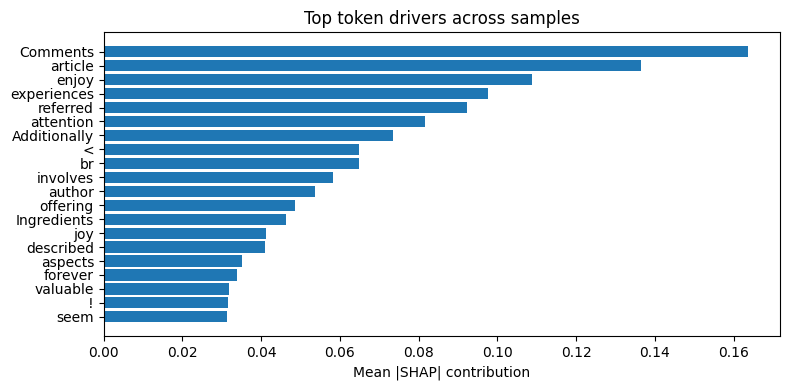

In [ ]:
if not token_importance.empty:
    plt.figure(figsize=(8, 4))
    plt.barh(token_importance["token"][::-1], token_importance["mean_abs_score"][::-1])
    plt.xlabel("Mean |SHAP| contribution")
    plt.title("Top token drivers across samples")
    plt.tight_layout()
    plt.show()
else:
    print("No aggregated token importance available.")

In [ ]:
truth = 'AI, 1' if labels[0] == 1 else 'Human, 0'
print(f'Ground truth: {truth}')
prediction = clf(texts[0], top_k=1)[0]
print(f"Predicted class: {prediction['label']} ({prediction['score']:.3f})")
shap.plots.text(shap_values[0])


Ground truth: Human, 0


In [ ]:
sample_idx = 6  # Change this index to view different examples
truth = 'AI, 1' if labels[sample_idx] == 1 else 'Human, 0'
print(f'Ground truth: {truth}')
prediction = clf(texts[sample_idx], top_k=1)[0]
print(f"Predicted class: {prediction['label']} ({prediction['score']:.3f})")
shap.plots.text(shap_values[sample_idx])


Ground truth: Human, 0
Predicted class: [{'label': 'LABEL_1', 'score': 0.9954379200935364}, {'label': 'LABEL_0', 'score': 0.004562051966786385}]
